In [45]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = '/Colab Notebooks/cs231n/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

#this allows the colab VM to load the python files within it
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))


%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/cs231n/assignment1/cs231n/datasets
/content/drive/My Drive/Colab Notebooks/cs231n/assignment1


**Outcomes**


1.   Implement a fully vectorized loss function for this classifier
2.   Implement the fully-vectorized expression for its analytic gradient
3.   Check the implementation with numerical gradient
4.   Use a validation set to tune the learning rate and the regularization strength.
5.   Optimize the loss function with SGD.
6.   Visualize the learned weights



In [46]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


In [47]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  #Load the CIFAR 10 dataset and perform preprocessing to prepare it for the linear classifier

  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

  #Cleaning up variables
  try:
    del X_train, y_train
    del X_test, y_test
    print('Cleaned up variables')
  except:
    pass

  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

  #Subsample the data
  mask = list(range(num_training, num_training + num_validation))
  X_val = X_train[mask]
  y_val = y_train[mask]

  mask = list(range(num_training))
  X_train = X_train[mask]
  y_train = y_train[mask]

  mask = list(range(num_test))
  X_test = X_test[mask]
  y_test = y_test[mask]

  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]

  #Preprocess; reshape the input data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

  #normalize the data; subtract the mean image
  mean_image = np.mean(X_train, axis=0),
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image

  #Add the bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev

# Use the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)


Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


# Softmax Classifier

In [48]:
input_dims = X_train.shape[1]
num_classes = 10
W = 0.001 * np.random.randn(input_dims, num_classes)

In [49]:
def softmax_loss_vectorized(W, X, y, reg):
  scores = X.dot(W)
  scores -= np.max(scores, axis=1, keepdims=True)

  probs = np.exp(scores) / np.sum(np.exp(scores), axis=1, keepdims=True)

  N = X.shape[0]
  correct_logprobs = -np.log(probs[np.arange(N), y] + 1e-15)
  loss = np.sum(correct_logprobs) /N
  loss += 0.5 * reg * np.sum(W * W)

  dscores = probs
  dscores[np.arange(N), y] -= 1
  dW = X.T.dot(dscores)/N
  dW += reg * W

  return loss, dW

**Train with SGD**

In [50]:
def train_softmax(X, y, X_val, y_val, learning_rate=1e-7, reg=4e4, num_iters=1800, batch_size=200, verbose=True):
  num_train, dim = X.shape
  num_classes = np.max(y) + 1
  W = 0.001 * np.random.randn(dim, num_classes)
  loss_history = []

  for it in range(num_iters):
    batch_indices = np.random.choice(num_train, batch_size)
    X_batch = X[batch_indices]
    y_batch = y[batch_indices]

    loss, grad = softmax_loss_vectorized(W, X_batch, y_batch, reg)
    loss_history.append(loss)
    W -= learning_rate * grad

    if verbose:
      if it % 100==0:
        print(f'At iteration{it}/{num_iters}, the loss is{loss}')

  return W, loss_history

**Train and Evaluate**

In [51]:
W_trained, loss_history = train_softmax(X_train, y_train, X_val, y_val)

def predict(X, W):
  scores = X.dot(W)
  y_pred = np.argmax(scores, axis=1)
  return y_pred

#training accuracy
y_train_pred = predict(X_train, W_trained)
print('Training accuracy: ', np.mean(y_train == y_train_pred))

#validation accuracy
y_val_pred = predict(X_val, W_trained)
print('Validation accuracy: ', np.mean(y_val == y_val_pred))

At iteration0/1800, the loss is619.3242027307354
At iteration100/1800, the loss is278.11744693659404
At iteration200/1800, the loss is125.43140233864341
At iteration300/1800, the loss is57.37234593958555
At iteration400/1800, the loss is26.776554544194937
At iteration500/1800, the loss is13.113497486776591
At iteration600/1800, the loss is6.989054838166469
At iteration700/1800, the loss is4.240084377172511
At iteration800/1800, the loss is3.0746693183382012
At iteration900/1800, the loss is2.511121308284866
At iteration1000/1800, the loss is2.317120241705937
At iteration1100/1800, the loss is2.1454454288757256
At iteration1200/1800, the loss is2.094114046115269
At iteration1300/1800, the loss is2.093250677695073
At iteration1400/1800, the loss is2.095979997687928
At iteration1500/1800, the loss is2.0842253291875426
At iteration1600/1800, the loss is2.052891589578618
At iteration1700/1800, the loss is2.0361610711926037
Training accuracy:  0.33746938775510205
Validation accuracy:  0.346


In [52]:
learning_rates = [1e-7, 5e-7, 1e-6]
regularization_strengths = [5e4, 4e4, 6e4]

results = {}
best_val = -1
best_W = None

for lr in learning_rates:
    for reg in regularization_strengths:
        print(f'Training with lr={lr}, reg={reg}')
        W_tmp, loss_hist = train_softmax(X_train, y_train, X_val, y_val,
                                         learning_rate=lr, reg=reg, num_iters=1500, verbose=False)

        y_train_pred = predict(X_train, W_tmp)
        train_acc = np.mean(y_train_pred == y_train)

        y_val_pred = predict(X_val, W_tmp)
        val_acc = np.mean(y_val_pred == y_val)

        results[(lr, reg)] = (train_acc, val_acc)

        if val_acc > best_val:
            best_val = val_acc
            best_W = W_tmp
        print(f'Train acc: {train_acc:.4f}, Val acc: {val_acc:.4f}')

print('\nBest validation accuracy achieved during cross-validation: %f' % best_val)

Training with lr=1e-07, reg=50000.0
Train acc: 0.3327, Val acc: 0.3470
Training with lr=1e-07, reg=40000.0
Train acc: 0.3390, Val acc: 0.3550
Training with lr=1e-07, reg=60000.0
Train acc: 0.3286, Val acc: 0.3310
Training with lr=5e-07, reg=50000.0
Train acc: 0.3349, Val acc: 0.3480
Training with lr=5e-07, reg=40000.0
Train acc: 0.3319, Val acc: 0.3540
Training with lr=5e-07, reg=60000.0
Train acc: 0.3197, Val acc: 0.3330
Training with lr=1e-06, reg=50000.0
Train acc: 0.3242, Val acc: 0.3390
Training with lr=1e-06, reg=40000.0
Train acc: 0.3064, Val acc: 0.3260
Training with lr=1e-06, reg=60000.0
Train acc: 0.3147, Val acc: 0.3370

Best validation accuracy achieved during cross-validation: 0.355000


**Visualize Weights**

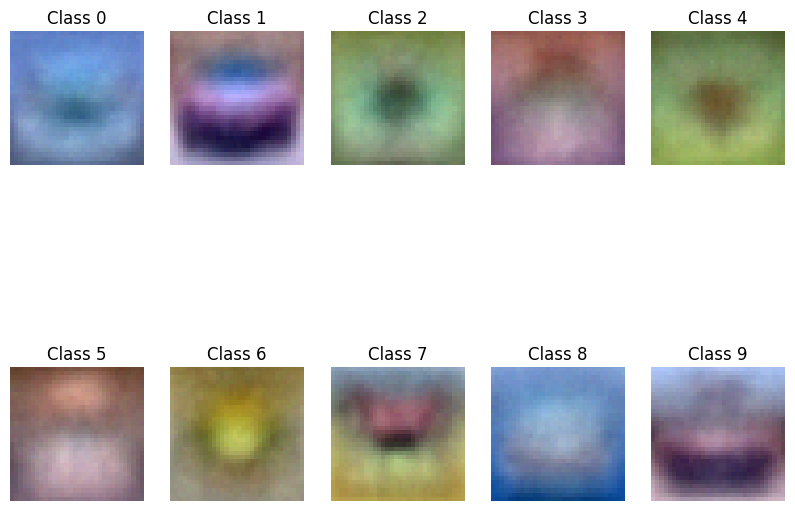

In [53]:
def visualize_weights(W):
  W = W[:-1, :] #remove bias term
  W = W.reshape(32, 32, 3, 10)
  W_min, W_max = np.min(W), np.max(W)

  for i in range(10):
    plt.subplot(2, 5, i+1)
    wimg = 255.0 * (W[:, :, :, i].squeeze() - W_min)/ (W_max - W_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(f'Class {i}')
  plt.show()

visualize_weights(W_trained)

